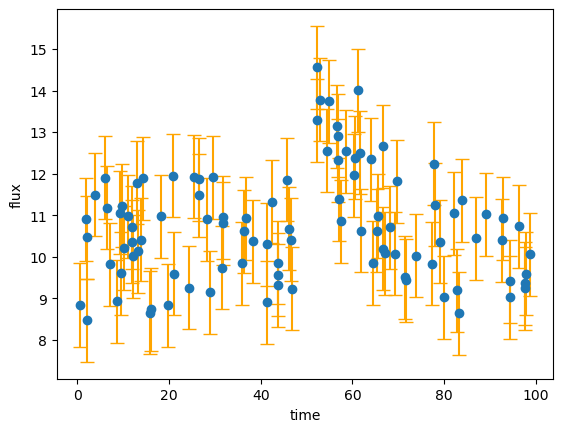

In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import math
import emcee
import corner

data=np.load('transient.npy')

time=data[:, 0]
flux=data[:, 1]
sigma=data[:, 2] 

plt.errorbar(time, flux, yerr=sigma, fmt='o', capsize=5, ecolor='orange') 
plt.xlabel("time")
plt.ylabel("flux")
plt.show()


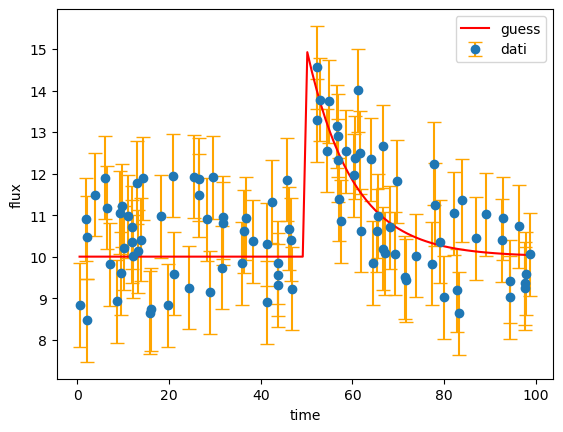

In [2]:
#guardo a occhio quali potrebbero essere i valori per i parametri

t=np.linspace(min(time), max(time), 100)

b_guess=10
A_guess=5
t0_guess=50
alpha_guess=0.1

#definisco una funzione che calcola il flusso in funzione del tempo
def model(b, A, t0, alpha, time):
    y=[]
    for i in range(0, len(time)):
        if time[i]<t0:
            y=np.append(y, b)
        else:
            y=np.append(y,b+A*np.exp(-alpha*(time[i]-t0)))
    return y

plt.errorbar(time, flux, yerr=sigma, fmt='o', capsize=5, ecolor='orange', label="dati")
plt.plot(t, model(b_guess, A_guess, t0_guess, alpha_guess, t), color='red', label="guess")
plt.legend()
plt.xlabel("time")
plt.ylabel("flux")
plt.show()


In [3]:
def LogLikelihood(params, time, flux, sigma): 
    # Gaussian likelihood 
    
    b, A, t0, alpha=params
    y1=model(b, A, t0, alpha, time)
    
    #calcolo logL perchè è più stabile di L (trascuro la normalizzazione perchè sto facendo parameter estimation)
    logL=np.sum(-(flux-y1)**2/(2*sigma**2))  
    
    return logL 

def LogPrior(params):    
    #prior uniforme per b, A, t0-> log(prior) è una costante (la trascuro)
    #prior loguniform per alpha
    b, A, t0, alpha=params
    if b>0 and b<50 and A>0 and A<50 and t0>0 and t0<100 and alpha>np.exp(-5) and alpha<np.exp(5):
        return np.log(1/alpha) 
    return -np.inf
        
def myLogPosterior(params, time, flux, sigma):
    return LogLikelihood(params, time, flux, sigma) + LogPrior(params)

In [4]:
ndim = 4       # number of parameters in the model
nwalkers = 20  # number of MCMC walkers
burn = 1000    # "burn-in" period 
nsteps = 10000  # number of MCMC steps to take for each walker

#scelti guardando il plot dei dati (inital guesses devono essere sensati), ordine:(b, A, t0, alpha)
param=[10, 5, 50 , 0.1]
#Aggiungo un rumore gaussiano a ciascuno guess in modo che non siano correlati
starting_guesses =np.array(param)+1e-1*np.random.randn(nwalkers, ndim)  

sampler = emcee.EnsembleSampler(nwalkers, ndim, myLogPosterior, args=[time, flux, sigma])
sampler.run_mcmc(starting_guesses, nsteps)

print("done")

C:\Users\leoni\anaconda3\Lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


done


In [5]:
print(sampler.chain.shape)
emcee_trace  = sampler.chain.reshape(-1, ndim) 
print(emcee_trace.shape)

(20, 10000, 4)
(200000, 4)


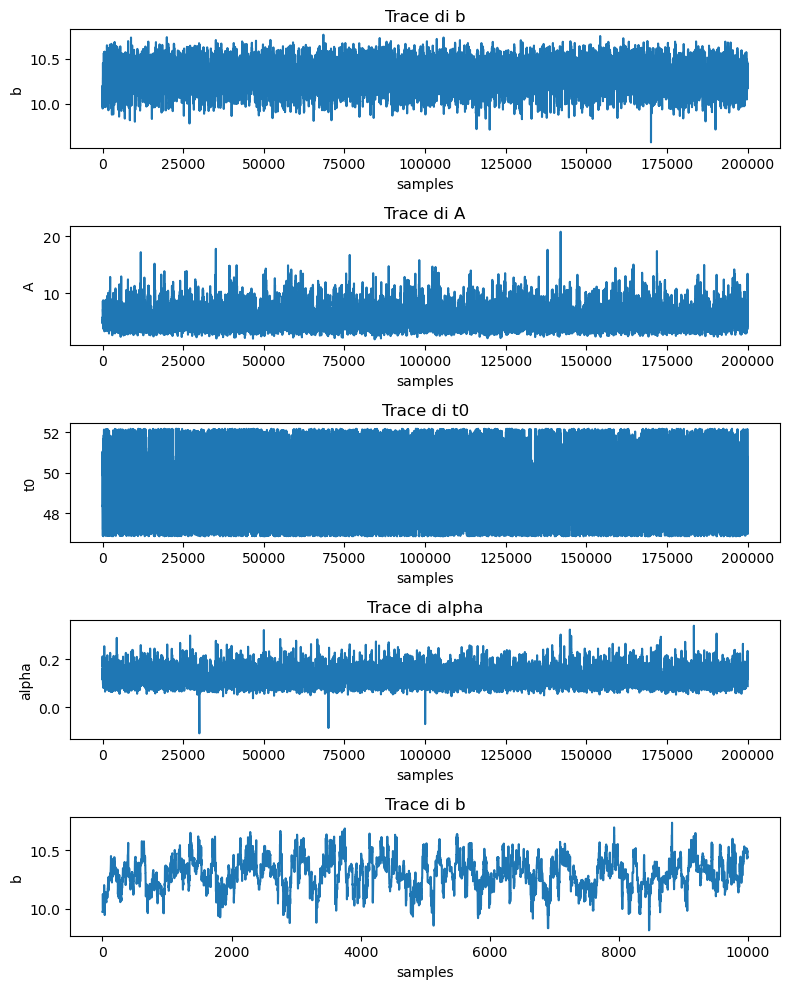

In [6]:
#distribuzioni dei 4 parametri
b_sporchi=emcee_trace[:, 0]
A_sporchi=emcee_trace[:, 1]
t0_sporchi=emcee_trace[:, 2]
alpha_sporchi=emcee_trace[:, 3]

sample=np.arange(1, nwalkers*nsteps+1)

#controllo le trace, chain con ancora burn in e autocorrelation
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(8, 10))

ax1.plot(sample, b_sporchi)
ax1.set_title('Trace di b')
ax1.set_xlabel('samples')
ax1.set_ylabel('b')

ax2.plot(sample, A_sporchi)
ax2.set_title('Trace di A')
ax2.set_xlabel('samples')
ax2.set_ylabel('A')

ax3.plot(sample, t0_sporchi)
ax3.set_title('Trace di t0')
ax3.set_xlabel('samples')
ax3.set_ylabel('t0')

ax4.plot(sample, alpha_sporchi)
ax4.set_title('Trace di alpha')
ax4.set_xlabel('samples')
ax4.set_ylabel('alpha')

ax5.plot(sample[:10000], b_sporchi[:10000])
ax5.set_title('Trace di b')
ax5.set_xlabel('samples')
ax5.set_ylabel('b')


# Mostra il plot
plt.tight_layout()
plt.show()


In [7]:
#faccio burn-in e tolgo autocorrelation
tau = sampler.get_autocorr_time()
print(tau)
thin = int(max(tau) + 1) 
print("thinning: ", thin)

chain = sampler.get_chain(discard=burn, thin=thin, flat=True) 
print(chain.shape)

#walkers=8 & nsteps=10000 autocorr_max=94 samples finali=760
#walkers=15 & nsteps=10000 autocorr_max=83 samples finali=1620 
#walkers=15 & nsteps=20000 autocorr_max=86 samples finali=3300 
#walkers=20 & nsteps=10000 autocorr_max=82 samples finali=2180 
#i valori delle mediane non sono cambiati molto nei 4 casi

[57.37158073 69.58010173 68.96900782 57.75613394]
thinning:  70
(2560, 4)


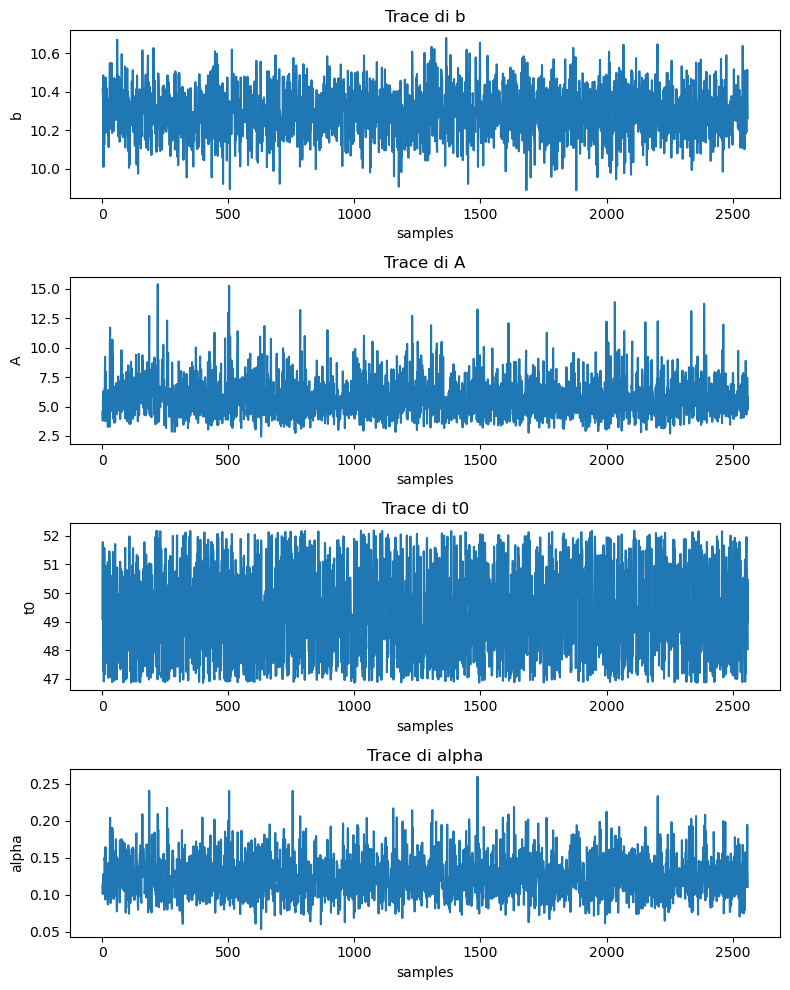

In [8]:
b=chain[:, 0]
A=chain[:, 1]
t0=chain[:, 2]
alpha=chain[:, 3]

sample=np.arange(1, chain.shape[0]+1)

#controllo le trace
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(8, 10))

ax1.plot(sample, b)
ax1.set_title('Trace di b')
ax1.set_xlabel('samples')
ax1.set_ylabel('b')

ax2.plot(sample, A)
ax2.set_title('Trace di A')
ax2.set_xlabel('samples')
ax2.set_ylabel('A')

ax3.plot(sample, t0)
ax3.set_title('Trace di t0')
ax3.set_xlabel('samples')
ax3.set_ylabel('t0')

ax4.plot(sample, alpha)
ax4.set_title('Trace di alpha')
ax4.set_xlabel('samples')
ax4.set_ylabel('alpha')

# Mostra il plot
plt.tight_layout()
plt.show()

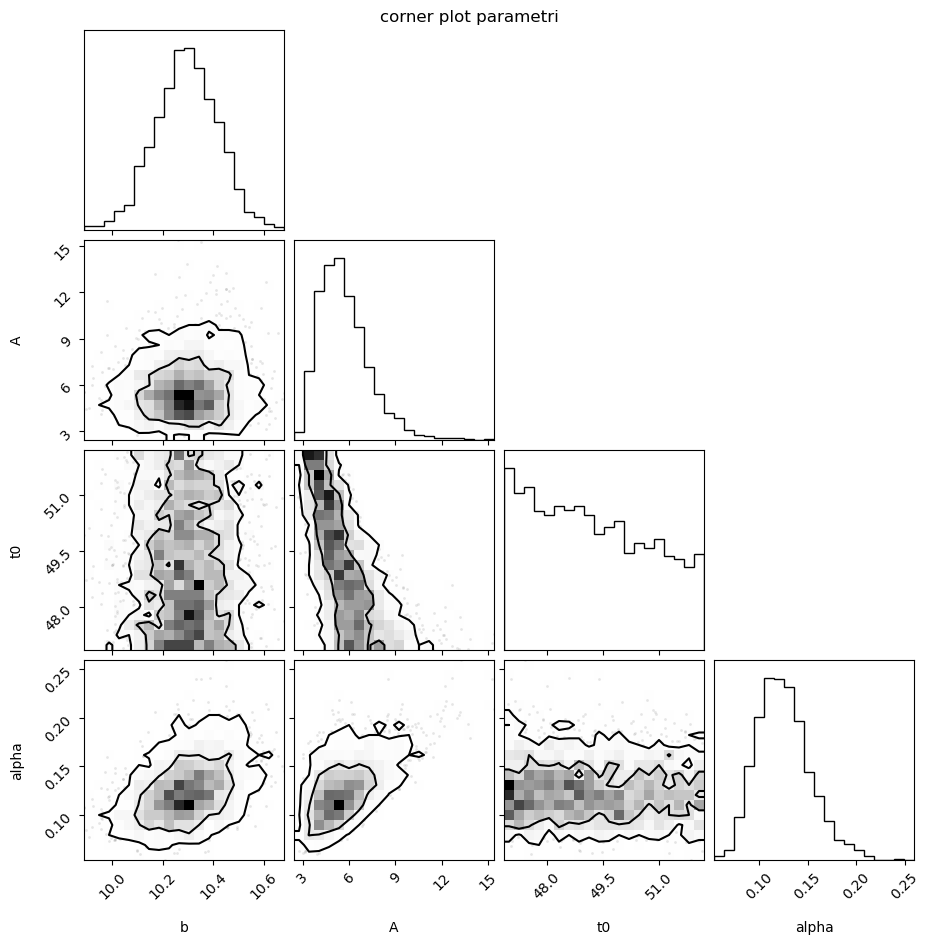

In [9]:
#corner plot
labels = ["b","A", "t0", "alpha"]

fig = corner.corner(chain, labels=labels, levels=[0.68,0.95])
fig.suptitle("corner plot parametri");


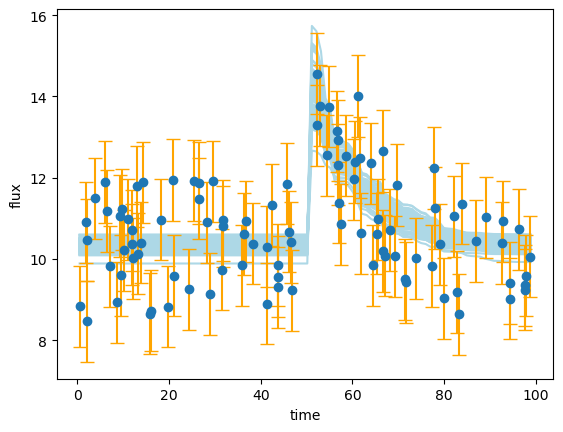

In [11]:
#Prendo dei set di parametri vedere come sono distribuiti, posso farlo perchè sono tutti equiprobabili

indici=np.random.choice(b.shape[0], size=100, replace=False)
b100=b[indici]
A100=A[indici]
t0100=t0[indici]
alpha100=alpha[indici]

for i in range(0,len(b100)):
    y=model(b100[i],A100[i],t0100[i],alpha100[i],time)
    plt.plot(t, y, color='lightblue')
plt.errorbar(time, flux, yerr=sigma, fmt='o', capsize=5, ecolor='orange')
plt.xlabel("time")
plt.ylabel("flux")
plt.show()

In [12]:
best_b=np.median(b)
best_A=np.median(A)
best_t0=np.median(t0)
best_alpha=np.median(alpha)

param=[b, A, t0, alpha]
nomi=["b", "A", "t0", "alpha"]

for par,lab in zip(param, nomi):
    best=np.median(par)
    lower_percentile = np.percentile(par, 5)  
    upper_percentile = np.percentile(par, 95)
    
    print("mediana di ", lab," : ", best, " - ", best-lower_percentile, " + ", upper_percentile-best, "al 90% di credibilità")


mediana di  b  :  10.294519170488815  -  0.20427084587852562  +  0.19586807360556335 al 90% di credibilità
mediana di  A  :  5.425089572504923  -  1.8361504984698693  +  3.426725778063707 al 90% di credibilità
mediana di  t0  :  49.070065873845465  -  2.0207569339527964  +  2.7645670403191005 al 90% di credibilità
mediana di  alpha  :  0.12255998086922534  -  0.03773656338296001  +  0.05243928515319138 al 90% di credibilità


# LEZ12

In [2]:
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

In [3]:
ndim=4

def burst(b, A, t0, alpha, time):
    y=[]
    for i in range(0, len(time)):
        if time[i]<t0:
            y=np.append(y, b)
        else:
            y=np.append(y,b+A*np.exp(-alpha*(time[i]-t0)))
    return y

def loglike(params, time, flux, sigma):
   
    #posso non normalizzarla perchè è la stessa per entrambi i modelli
    b, A, t0, alpha=params
    y1=burst(b, A, t0, alpha, time)
    
    #calcolo logL perchè è più stabile di L
    logL=np.sum(-(flux-y1)**2/(2*sigma**2))  
    
    return logL
 
def ptform(u):
    """
    Per fare la trasformazione uguaglio la cdf di u con quella del parametro finale
    """
    b=0+(50-0)*u[0]
    A=0+(50-0)*u[1]
    t0=0+(100-0)*u[2]
    alpha=np.exp(-5)*(np.exp(5)/np.exp(-5))**u[3]
    
    return np.array([b, A, t0, alpha])

In [4]:
sampler = dynesty.NestedSampler(loglike, ptform, ndim, logl_args=[time, flux, sigma], nlive=1000, sample='rslice')
sampler.run_nested()


14452it [06:09, 39.14it/s, +1000 | bound: 34 | nc: 1 | ncall: 478153 | eff(%):  3.238 | loglstar:   -inf < -48.765 <    inf | logz: -63.100 +/-  0.122 | dlogz:  0.001 >  1.009]


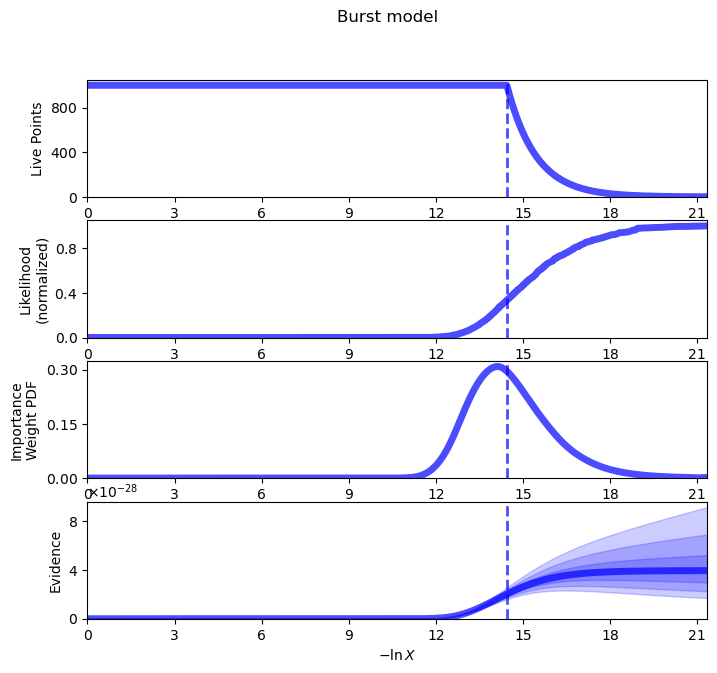

In [5]:
sresults = sampler.results
rfig, raxes = dyplot.runplot(sresults)
rfig.set_size_inches(8, 7) 
rfig.suptitle("Burst model")
plt.show()

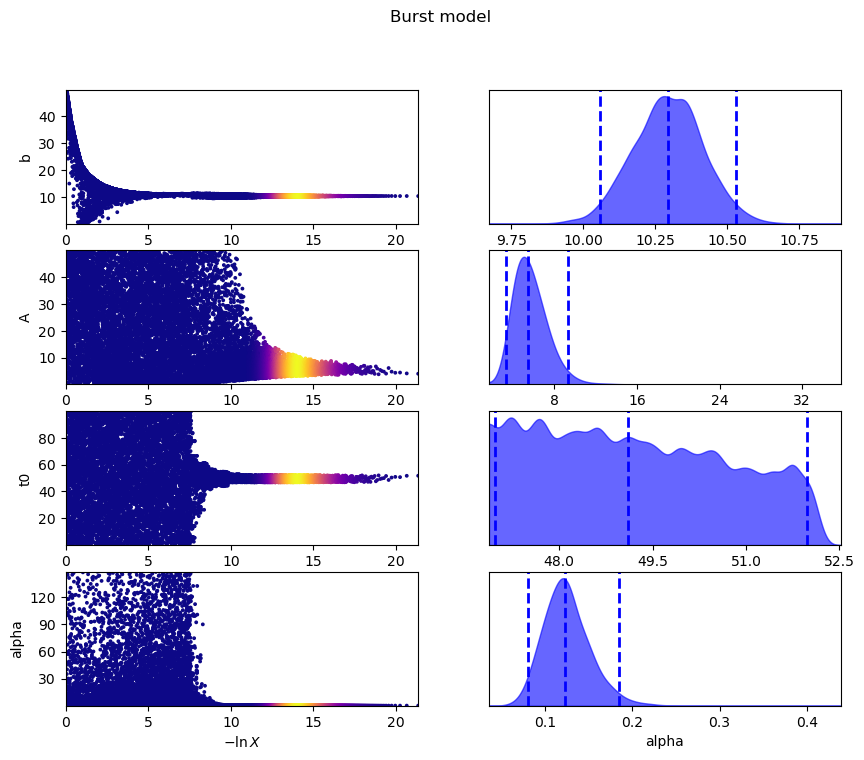

In [6]:
labels = ["b","A", "t0", "alpha"]
tfig, taxes = dyplot.traceplot(sresults, labels=labels) 
tfig.suptitle("Burst model")
tfig.set_size_inches(10, 8) 

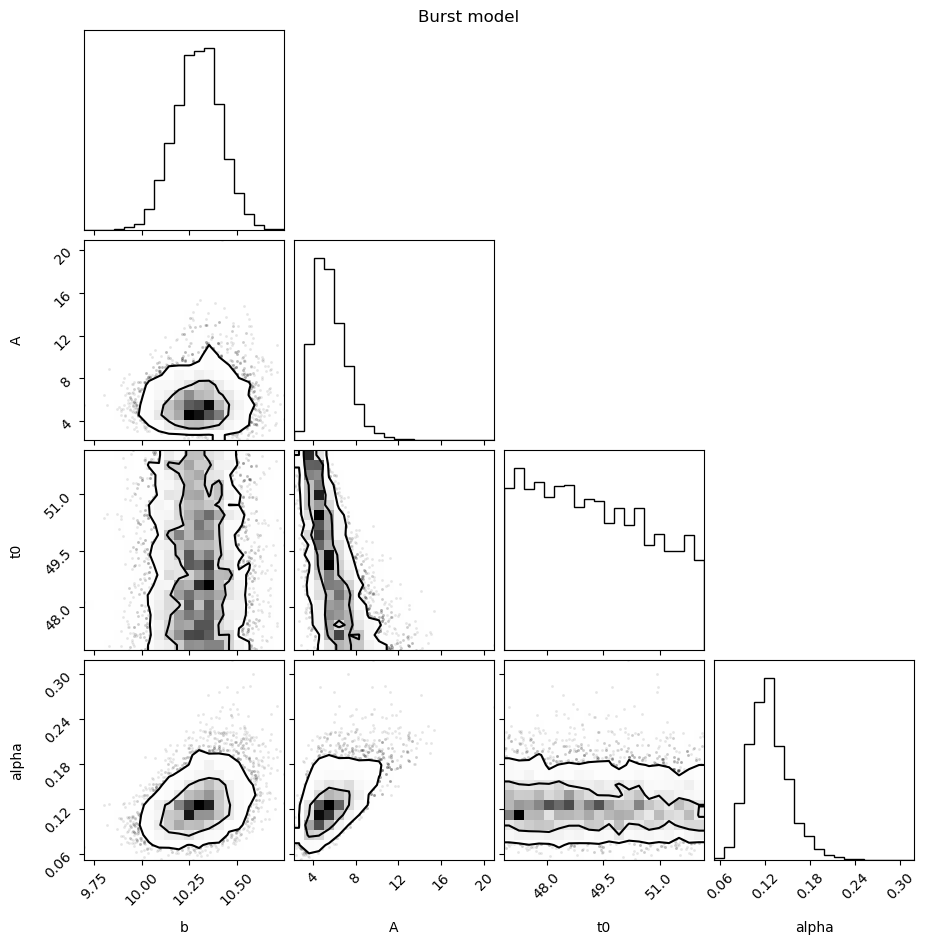

In [7]:
samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights
#print(samples)

labels = ["b","A", "t0", "alpha"]
samples_equal = dyfunc.resample_equal(samples, weights)
fig = corner.corner(samples_equal, labels=labels, levels=[0.68,0.95])
fig.suptitle("Burst model")
plt.show()

In [8]:
evidence = sresults.logz[-1]          #log(evidence)
evidence_err = sresults.logzerr[-1]   #dynesty mi da stima sull'errore associato a evidence

b=samples_equal[:, 0]
A=samples_equal[:, 1]
t0=samples_equal[:, 2]
alpha=samples_equal[:, 3]

param=[b, A, t0, alpha]
nomi=["b", "A", "t0", "alpha"]

for par,lab in zip(param, nomi):
    best=np.median(par)
    lower_percentile = np.percentile(par, 5)  
    upper_percentile = np.percentile(par, 95)
    
    print("mediana di ", lab," : ", best, " - ", best-lower_percentile, " + ", upper_percentile-best, "al 90% di credibilità")

mediana di  b  :  10.295667370916139  -  0.20013519221286913  +  0.19442058081191682 al 90% di credibilità
mediana di  A  :  5.440482958770233  -  1.8518134751659097  +  3.1719787806767252 al 90% di credibilità
mediana di  t0  :  49.12543927652758  -  2.0346500203063798  +  2.6637343130479323 al 90% di credibilità
mediana di  alpha  :  0.1223854796062819  -  0.03574717611403849  +  0.050901555166527834 al 90% di credibilità


## GAUSSIAN MODEL

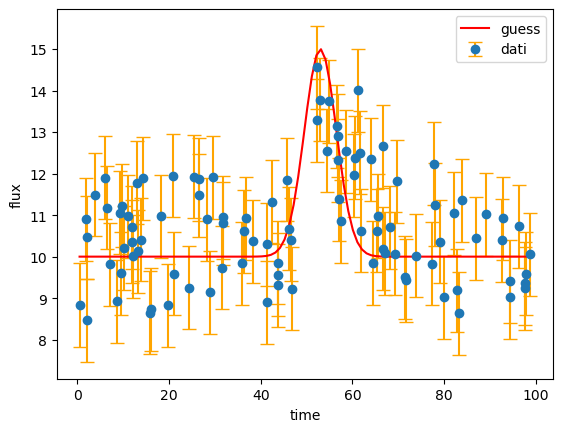

In [9]:
#fit con gaussiana
def gaussian(bg, Ag, t0g, sigmag, time):
    return bg+Ag*np.exp(-(time-t0g)**2/(2*sigmag**2))

t=np.linspace(min(time), max(time), 100)

bg_guess=10
Ag_guess=5
t0g_guess=53
sigmag_guess=3.5

plt.errorbar(time, flux, yerr=sigma, fmt='o', capsize=5, ecolor='orange', label="dati")
plt.plot(t, gaussian(bg_guess, Ag_guess, t0g_guess, sigmag_guess, t), color='red', label="guess")
plt.legend()
plt.xlabel("time")
plt.ylabel("flux")
plt.show()

In [18]:
ndim=4

def loglike(params, time, flux, sigma):
    
    #posso non normalizzarla perchè è la stessa per entrambi i modelli
    bg, Ag, t0g, sigmag=params
    y1=gaussian(bg, Ag, t0g, sigmag, time)
    
    #calcolo logL perchè è più stabile di L
    logL=np.sum(-(flux-y1)**2/(2*sigma**2))  
    
    return logL
 
def ptform(u):
    '''
    bg, Ag, t0g sono distribuiti uniformemente, sigmag è distribuito loguniform
    '''
    bg=0+(50-0)*u[0]
    Ag=0+(50-0)*u[1]
    t0g=0+(100-0)*u[2]
    sigmag=np.exp(-2)*(np.exp(3)/np.exp(-2))**u[3]
    #sigmag=scipy.stats.loguniform.ppf(u[3],np.exp(-5),np.exp(5))
    return np.array([bg, Ag, t0g, sigmag])

In [19]:
sampler_g = dynesty.NestedSampler(loglike, ptform, ndim, logl_args=[time, flux, sigma], nlive=1000, sample='rslice')
sampler_g.run_nested()

16325it [00:39, 415.08it/s, +1000 | bound: 39 | nc: 1 | ncall: 569873 | eff(%):  3.045 | loglstar:   -inf < -52.425 <    inf | logz: -68.758 +/-  0.137 | dlogz:  0.001 >  1.009]


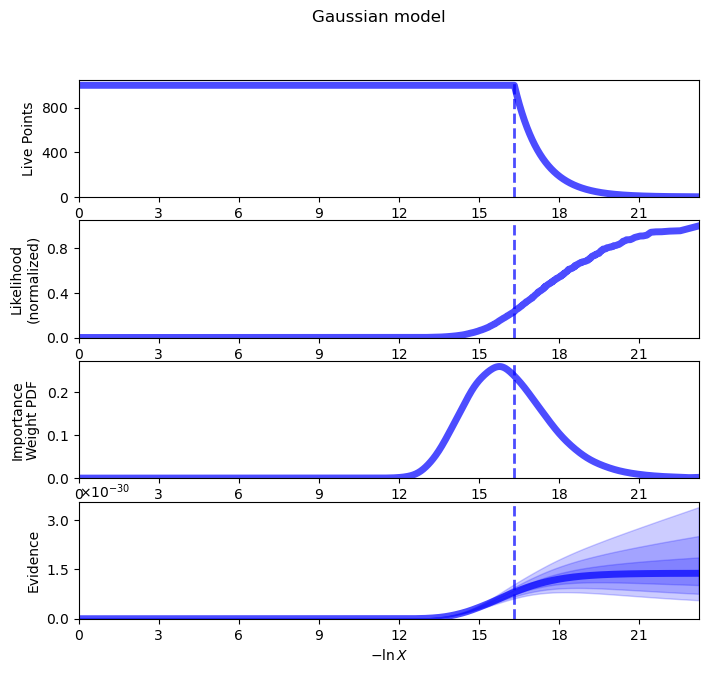

In [20]:
sresults_g = sampler_g.results
rfig, raxes = dyplot.runplot(sresults_g)
rfig.set_size_inches(8, 7) 
rfig.suptitle("Gaussian model")
plt.show()

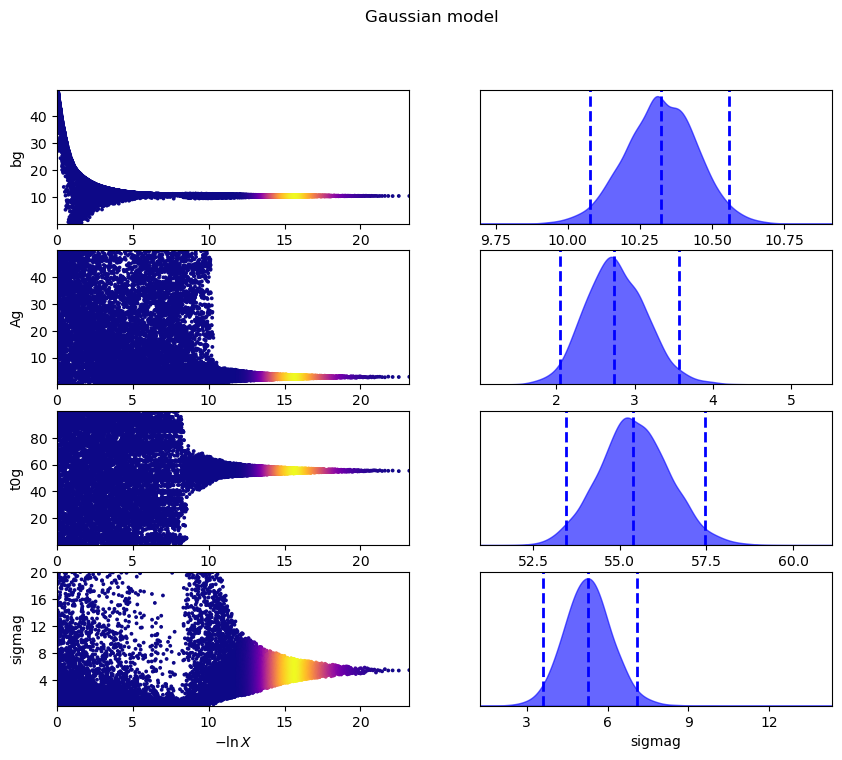

In [21]:
labels = ["bg","Ag", "t0g", "sigmag"]
tfig, taxes = dyplot.traceplot(sresults_g, labels=labels)
tfig.set_size_inches(10, 8) 
tfig.suptitle("Gaussian model")
plt.show()

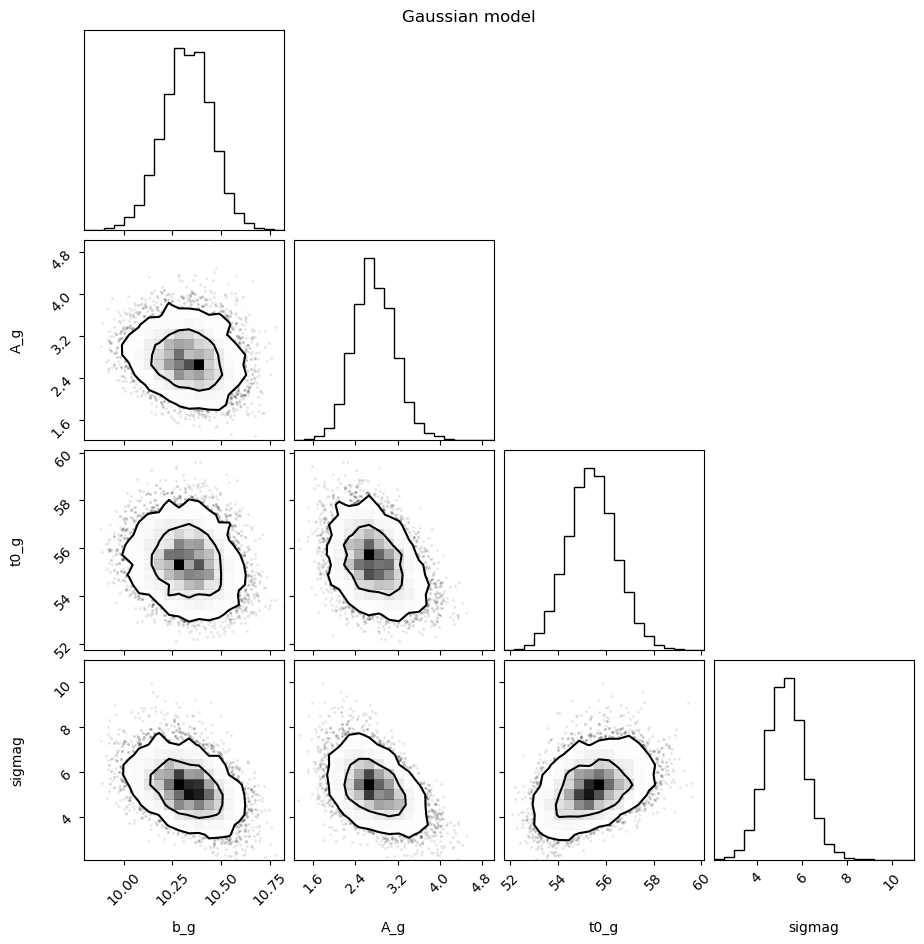

In [22]:
samples_g = sresults_g.samples                              # samples
weights_g = np.exp(sresults_g.logwt - sresults_g.logz[-1])  # normalized weights
#print(samples)
labels = ["b_g","A_g", "t0_g", "sigmag"]
samples_equal_g = dyfunc.resample_equal(samples_g, weights_g)
fig = corner.corner(samples_equal_g, labels=labels, levels=[0.68,0.95])
fig.suptitle("Gaussian model")
plt.show()


In [23]:
evidence_g = sresults_g.logz[-1]        #log(evidence)
evidence_err_g = sresults_g.logzerr[-1] 

bg=samples_equal_g[:, 0]
Ag=samples_equal_g[:, 1]
t0g=samples_equal_g[:, 2]
sigmag=samples_equal_g[:, 3]

param=[bg, Ag, t0g, sigmag]
nomi=["bg", "Ag", "t0g", "sigmag"]

for par,lab in zip(param, nomi):
    best=np.median(par)
    lower_percentile = np.percentile(par, 5)  
    upper_percentile = np.percentile(par, 95)
    
    print("mediana di ", lab," : ", best, " - ", best-lower_percentile, " + ", upper_percentile-best, "al 90% di credibilità")


mediana di  bg  :  10.324037361716618  -  0.20476133152632414  +  0.19698706895680473 al 90% di credibilità
mediana di  Ag  :  2.738185631007214  -  0.5823362083486021  +  0.6652431050815792 al 90% di credibilità
mediana di  t0g  :  55.38371753696728  -  1.6192700930469996  +  1.7154873754482622 al 90% di credibilità
mediana di  sigmag  :  5.266925469500633  -  1.3942522513644726  +  1.469206180585167 al 90% di credibilità


In [24]:
bayes=np.exp(evidence)/np.exp(evidence_g)
bayes_err=bayes*np.sqrt(evidence_err**2+evidence_err_g**2) 
print(bayes, "+/-", bayes_err)

#valori ottenuti con dlogz=0.001, livep=500 per burst e live=900 per gauss
#295 +/- 125
#176 +/- 74
#242 +/- 103

#per rendere più robusta la stima ho cambiato il metodo di campionamento:

#valori ottenuti con dlogz=0.001, livep=1000, sample=rslice
#169.12 +/- 69.15
#135.96 +/- 55.95

286.4479914455256 +/- 117.60041115073695


Dall'Odds ratio si vede che il burst model è 100 volte più probabile del gaussian model, quindi tra i due il modello migliore è il burst

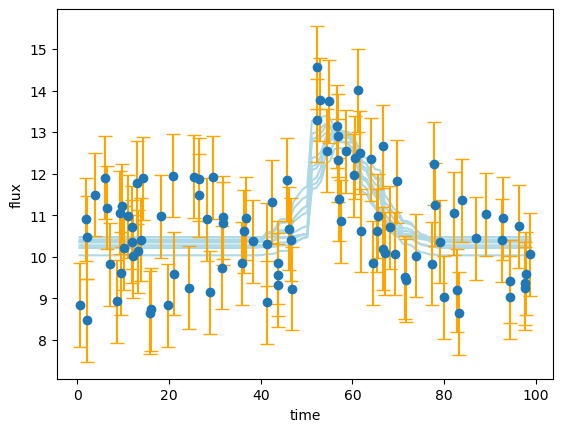

In [17]:
bg=samples_equal_g[:, 0]
Ag=samples_equal_g[:, 1]
t0g=samples_equal_g[:, 2]
sigmag=samples_equal_g[:, 3]

indici=np.random.choice(bg.shape[0], size=10, replace=False)
bg100=bg[indici]
Ag100=Ag[indici]
t0g100=t0g[indici]
sigmag100=sigmag[indici]

for i in range(0,len(bg100)):
    y=gaussian(bg100[i],Ag100[i],t0g100[i],sigmag100[i],time)
    plt.plot(t, y, color='lightblue')#, alpha=1)
plt.errorbar(time, flux, yerr=sigma, fmt='o', capsize=5, ecolor='orange', label="dati")

plt.xlabel("time")
plt.ylabel("flux")
plt.show()


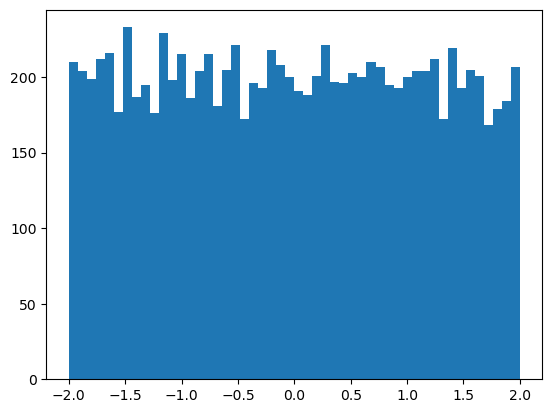

In [81]:
#controllo di aver fatto bene la trasformazione per sigmag
u1=np.random.uniform(0,1, 10000)

sigmag=np.exp(-2)*(np.exp(2)/np.exp(-2))**u1
plt.hist(np.log(sigmag), bins=50)
plt.show()